In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
import wave,os,librosa,tqdm,time,shutil
import pandas as pd
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa, os, cv2, pickle, tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization,Input
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adadelta,Adagrad,Adamax,Nadam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [3]:
feats = pd.read_csv('/kaggle/input/crema-d-opensmile-all-emo-16khz-20db-trim-then-nr/CREMA_D_OpenSMILE_Features_16khz_trim_then_NR.csv')

In [15]:
def split_preprocess(df,apply_smote=False,rs=536,returnscalerle=False):
  x = df.drop(['label'], axis=1)
  y = df['label']
  trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=rs,stratify=y)
  scaler = StandardScaler()
  trainX = scaler.fit_transform(trainX)
  testX = scaler.transform(testX)
  if apply_smote:
    smote = SMOTE(random_state=42)
    trainX, trainY = smote.fit_resample(trainX, trainY)
  le = LabelEncoder()
  trainY_enc = to_categorical(le.fit_transform(trainY))
  testY_enc = to_categorical(le.transform(testY))
  if returnscalerle:
    return trainX, testX, trainY, testY, trainY_enc,testY_enc, scaler,le
  return trainX, testX, trainY, testY,trainY_enc,testY_enc

In [64]:
trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le = split_preprocess(feats,rs=502,returnscalerle=True)
model = Sequential()
model.add(Input((trainX.shape[1],)))
model.add(Dense(20, activation='relu',kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(40, activation='relu',kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(80, activation='relu',kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(np.unique(trainY)), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_211"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_847 (Dense)               │ (None, 20)             │       127,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_323         │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_519 (Dropout)           │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_848 (Dense)               │ (None, 40)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_324         │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_520 (Dropout)           │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_849 (Dense)               │ (None, 80)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_325         │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_521 (Dropout)           │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_850 (Dense)               │ (None, 6)              │           486 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,646 (518.15 KB)

 Trainable params: 132,366 (517.05 KB)

 Non-trainable params: 280 (1.09 KB)

In [65]:
mpath = '/kaggle/working/ann_model_cremad_opensmile.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001),
             tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
history = model.fit(trainX, trainY_enc, epochs=300, batch_size=64, validation_data=(testX, testY_enc),callbacks=callbacks)
_, accuracy = model.evaluate(testX, testY_enc)
print('\nAccuracy: %.2f' % (accuracy*100))
predictions = model.predict(testX)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))
print(classification_report(testY, predicted_labels))
new_mpath = f"/kaggle/working/ann_model_cremad_opensmile_val_acc_{accuracy*100:.2f}.keras"
shutil.move(mpath, new_mpath)

Epoch 1/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3063 - loss: 3.0894
Epoch 1: val_accuracy improved from -inf to 0.43788, saving model to /kaggle/working/ann_model_cremad_opensmile.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.3068 - loss: 3.0873 - val_accuracy: 0.4379 - val_loss: 2.4839 - learning_rate: 0.0010
Epoch 2/300
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4191 - loss: 2.5263
Epoch 2: val_accuracy improved from 0.43788 to 0.49161, saving model to /kaggle/working/ann_model_cremad_opensmile.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4197 - loss: 2.5209 - val_accuracy: 0.4916 - val_loss: 2.2276 - learning_rate: 0.0010
Epoch 3/300
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4740 - loss: 2.2266
Epoch 3: val_accuracy improved from 0.49161 to 0.53862, saving model to /kaggle/working/ann_model_cremad_opensmile.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4744 - loss: 2.2234 - val_accuracy: 0.5386 - val_lo

'/kaggle/working/ann_model_cremad_opensmile_val_acc_58.29.keras'

In [14]:
pip install keras_tuner

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [49]:
from tensorflow.keras.regularizers import l1,l2,l1_l2
def getRandomHPPMS():
    params = {}
    #params['rs_split'] = np.random.randint(0,1000)
    params['rs_split'] = 502
    params['num_HL'] = np.random.randint(2,4+1)
    for i in range(1,params['num_HL']+1):
        params[f'units_{i}'] = np.random.choice(range(128,512+2,2))
        params[f'KR_{i}'] = np.random.choice(['l1','l2','l1l2','none'])
        params[f'BN_{i}'] = np.random.choice([True,False])
        #params[f'dropout_rate_{i}'] = np.random.choice(np.round(np.arange(0,0.5+0.1,0.1),1))
        params[f'dropout_rate_{i}'] = np.round(np.random.uniform(0,0.5),4)
    params['learning_rate'] = np.random.uniform(0.0001,0.005)
    optims = ['Adam','SGD','RMSprop','Adadelta','Adagrad','Adamax','Nadam']
    params['optimizer'] = np.random.choice(optims)
    params['batch_size'] = np.random.choice(range(32,132,4))
    params['adpLR'] = np.random.choice([True,False])
    params['apply_smote'] = np.random.choice([True,False])
    return params

def buildntrainmodel(params,feats,max_epochs=500):
    trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le = split_preprocess(feats,rs=params['rs_split'],apply_smote=params['apply_smote'],returnscalerle=True)
    model = Sequential()
    model.add(Input((trainX.shape[1],)))
    for i in range(1,params['num_HL']+1):
        kern = {'l1':l1(),'l2':l2(),'l1l2':l1_l2(),'none':None}
        model.add(Dense(units=params[f'units_{i}'],activation='relu',kernel_regularizer=kern[params[f'KR_{i}']]))
        if params[f'BN_{i}']:
            model.add(BatchNormalization())
        if params[f'dropout_rate_{i}']>0:
            model.add(Dropout(params[f'dropout_rate_{i}']))
    model.add(Dense(len(np.unique(trainY)), activation='softmax'))
    optimizer_dict = {'Adam': Adam(learning_rate=params['learning_rate']),
                      'SGD': SGD(learning_rate=params['learning_rate']),
                      'RMSprop': RMSprop(learning_rate=params['learning_rate']),
                      'Adadelta': Adadelta(learning_rate=params['learning_rate']),
                      'Adagrad': Adagrad(learning_rate=params['learning_rate']),
                      'Adamax': Adamax(learning_rate=params['learning_rate']),
                      'Nadam': Nadam(learning_rate=params['learning_rate'])}
    
    model.compile(optimizer=optimizer_dict[params['optimizer']], loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)]
    if params['adpLR']:
        callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001))
    histann = model.fit(trainX, trainY_enc, epochs=max_epochs, batch_size=params['batch_size'],validation_data=(testX, testY_enc),callbacks=callbacks)
    _, accuracy = model.evaluate(testX, testY_enc)
    splits = (trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le)
    return accuracy,params,model,splits,histann

In [50]:
import IPython.display as ipd
def plot_history(hist,acc,id):
  plt.figure(figsize=(12, 6))
  plt.suptitle(f'Training & Validation Curves for Best ANN Model - Val_Acc={acc*100:.2f}% at Trial #{id}', fontsize=16)
  plt.subplot(1, 2, 1)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')

  plt.subplot(1, 2, 2)
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='lower right')
  plt.tight_layout()
  plt.show()

def tune_hyperparams(ntrials,feats,max_epochs=500):
    max_acc = 0
    totm = 0
    phist = dict()
    histories = dict()
    for i in range(1,ntrials+1):
        st = time.time()
        print(f"\nRunning Trial #{i}\n")
        params = getRandomHPPMS()
        if i==1:
            best_params = params
        print(f"{'Current Value':<15}{'|Best Value So Far':<21}{'|Hyperparameter'}")
        print(f"{'-' * 15}|{'-' * 20}|{'-' * 15}")
        for param, value in params.items():
            best_value = best_params.get(param, 'N/A')
            if param=='learning_rate':
                best_value,value = round(best_value,3),round(value,3)
            print(f"{str(value):<15}|{str(best_value):<20}|{param}")
        print()
        acc,params,model,splits,histann = buildntrainmodel(params,feats,max_epochs=max_epochs)
        trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le = splits
        fparams = frozenset(params.items())
        phist[fparams] = acc
        histories[i] = histann
        if acc>max_acc:
            max_acc = acc
            best_params = params
            best_trial = i
            best_model = model
        ipd.clear_output(wait=True)
        en = time.time()
        tm = en-st
        totm+=tm
        ep = len(histann.history['accuracy'])
        tracc = max(histann.history['accuracy'])
        print(f"Trial {i} Complete [{int(tm/3600)}h {int(tm/60)}m {int(tm%60)}s] - Trained for {ep} epochs")
        print(f"train_accuracy = {tracc*100:.3f}%")
        print(f"val_accuracy = {acc*100:.3f}%")
        print(f"Overfitting Difference = {(tracc-acc)*100:.3f}%\n")
        print(f"Best val_accuracy So Far: {max_acc*100:.3f}% at Trial #{best_trial}")
        print(f"Total time elapsed: [{int(totm/3600)}h {int(totm/60)}m {int(totm%60)}s]")
    print(f"Best Hyperparameters: {best_params}")
    print("Best Model Summary:")
    print(best_model.summary())
    best_hist = histories[best_trial]
    plot_history(best_hist,max_acc,best_trial)
    trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le = split_preprocess(feats,rs=best_params['rs_split'],apply_smote=best_params['apply_smote'],returnscalerle=True)
    predictions = best_model.predict(testX)
    predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))
    cm = confusion_matrix(testY, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for Best ANN Model")
    plt.show()
    print(f"\nAccuracy = {accuracy_score(testY,predicted_labels)*100:.3f}%\n")
    print(classification_report(testY, predicted_labels))
    best_model.save(f'/kaggle/working/ann_model_cremad_opensmile_val_acc_{max_acc*100:.3f}.keras')
    return max_acc, best_params, best_trial, best_model, phist,histories

Trial 20 Complete [0h 0m 34s] - Trained for 58 epochs
train_accuracy = 40.823%
val_accuracy = 42.176%
Overfitting Difference = -1.353%

Best val_accuracy So Far: 60.175% at Trial #9
Total time elapsed: [0h 18m 52s]
Best Hyperparameters: {'rs_split': 374, 'num_HL': 3, 'units_1': 254, 'KR_1': 'none', 'BN_1': True, 'dropout_rate_1': 0.2, 'units_2': 460, 'KR_2': 'none', 'BN_2': False, 'dropout_rate_2': 0.0, 'units_3': 170, 'KR_3': 'l1l2', 'BN_3': False, 'dropout_rate_3': 0.3, 'learning_rate': 0.002910436769059075, 'optimizer': 'Adagrad', 'batch_size': 112, 'adpLR': False, 'apply_smote': True}
Best Model Summary:


Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_287 (Dense)               │ (None, 254)            │     1,618,996 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_93          │ (None, 254)            │         1,016 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_169 (Dropout)           │ (None, 254)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_288 (Dense)               │ (None, 460)            │       117,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_289 (Dense)               │ (None, 170)            │        78,370 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_170 (Dropout)           │ (None, 170)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_290 (Dense)               │ (None, 6)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,632,910 (13.86 MB)

 Trainable params: 1,816,200 (6.93 MB)

 Non-trainable params: 508 (1.98 KB)

 Optimizer params: 1,816,202 (6.93 MB)

None


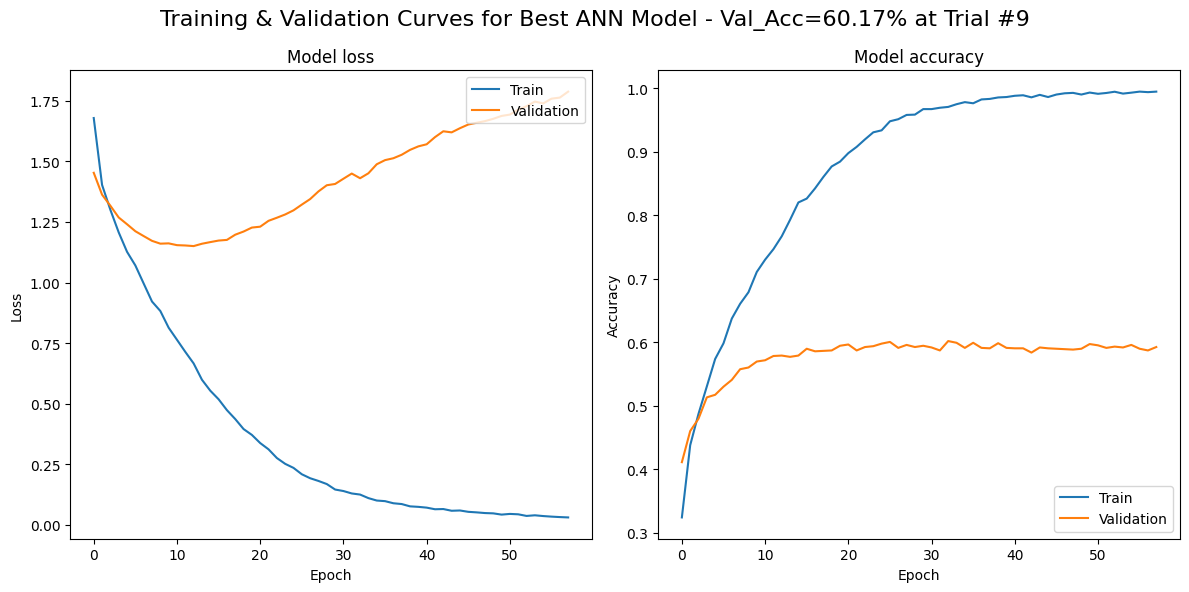

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


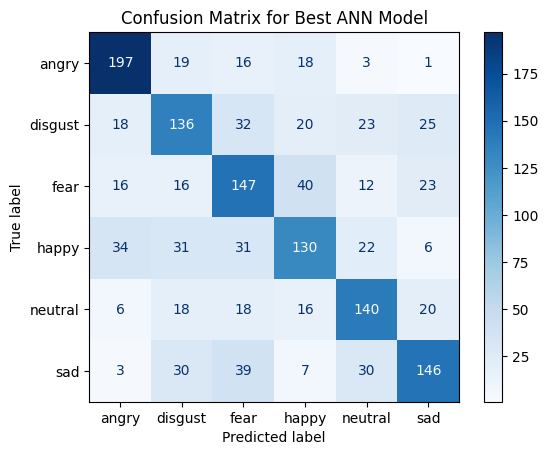


Accuracy = 60.175%

              precision    recall  f1-score   support

       angry       0.72      0.78      0.75       254
     disgust       0.54      0.54      0.54       254
        fear       0.52      0.58      0.55       254
       happy       0.56      0.51      0.54       254
     neutral       0.61      0.64      0.62       218
         sad       0.66      0.57      0.61       255

    accuracy                           0.60      1489
   macro avg       0.60      0.60      0.60      1489
weighted avg       0.60      0.60      0.60      1489



In [41]:
max_acc, best_params, best_trial, best_model, phist, histories = tune_hyperparams(ntrials=20,feats=feats,max_epochs=500)

Trial 20 Complete [0h 0m 26s] - Trained for 42 epochs
train_accuracy = 96.523%
val_accuracy = 55.876%
Overfitting Difference = 40.646%

Best val_accuracy So Far: 62.122% at Trial #7
Total time elapsed: [0h 17m 51s]
Best Hyperparameters: {'rs_split': 502, 'num_HL': 4, 'units_1': 508, 'KR_1': 'none', 'BN_1': True, 'dropout_rate_1': 0.2, 'units_2': 478, 'KR_2': 'none', 'BN_2': False, 'dropout_rate_2': 0.1, 'units_3': 462, 'KR_3': 'none', 'BN_3': True, 'dropout_rate_3': 0.4, 'units_4': 276, 'KR_4': 'l1', 'BN_4': False, 'dropout_rate_4': 0.1, 'learning_rate': 0.00027391575522267217, 'optimizer': 'Adamax', 'batch_size': 104, 'adpLR': True, 'apply_smote': True}
Best Model Summary:


Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_357 (Dense)               │ (None, 508)            │     3,237,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_120         │ (None, 508)            │         2,032 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_206 (Dropout)           │ (None, 508)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_358 (Dense)               │ (None, 478)            │       243,302 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_207 (Dropout)           │ (None, 478)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_359 (Dense)               │ (None, 462)            │       221,298 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_121         │ (None, 462)            │         1,848 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_208 (Dropout)           │ (None, 462)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_360 (Dense)               │ (None, 276)            │       127,788 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_209 (Dropout)           │ (None, 276)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_361 (Dense)               │ (None, 6)              │         1,662 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,503,888 (43.88 MB)

 Trainable params: 3,833,982 (14.63 MB)

 Non-trainable params: 1,940 (7.58 KB)

 Optimizer params: 7,667,966 (29.25 MB)

None


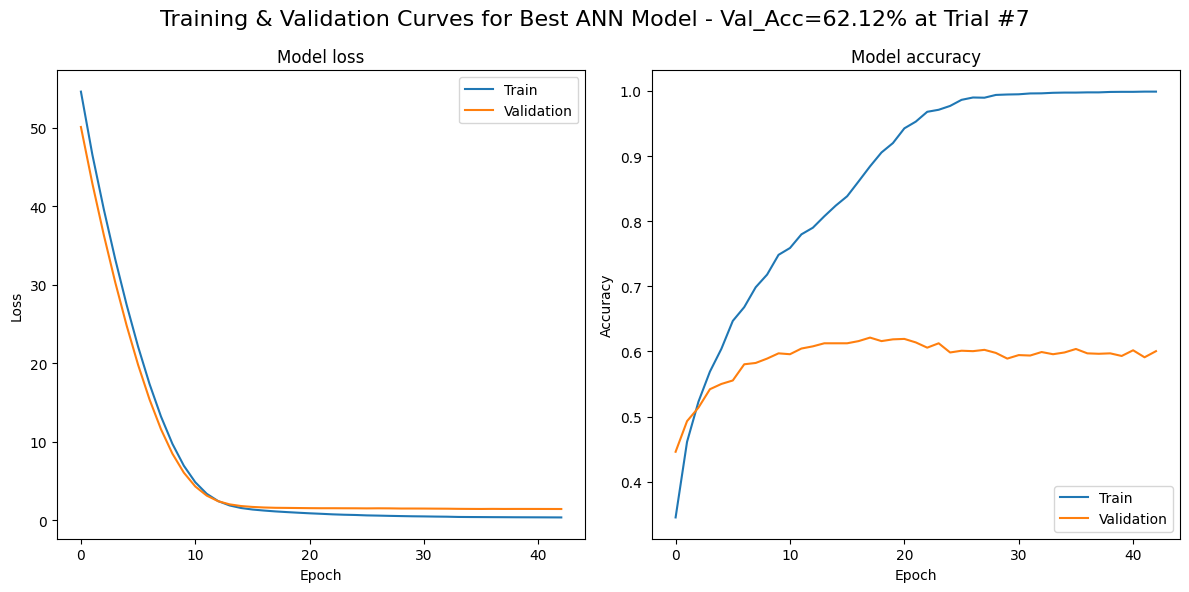

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


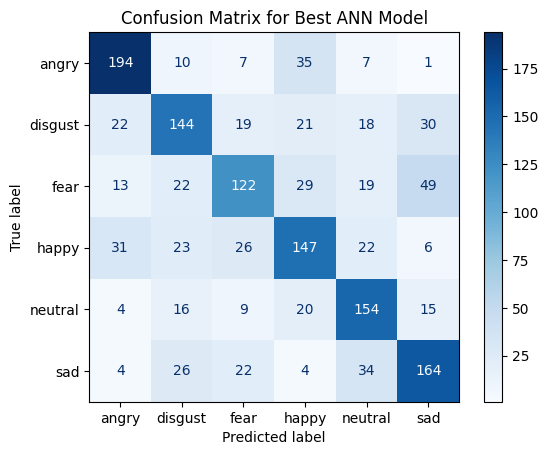


Accuracy = 62.122%

              precision    recall  f1-score   support

       angry       0.72      0.76      0.74       254
     disgust       0.60      0.57      0.58       254
        fear       0.60      0.48      0.53       254
       happy       0.57      0.58      0.58       255
     neutral       0.61      0.71      0.65       218
         sad       0.62      0.65      0.63       254

    accuracy                           0.62      1489
   macro avg       0.62      0.62      0.62      1489
weighted avg       0.62      0.62      0.62      1489



In [44]:
max_acc, best_params, best_trial, best_model, phist, histories = tune_hyperparams(ntrials=20,feats=feats,max_epochs=500)

Trial 20 Complete [0h 0m 59s] - Trained for 150 epochs
train_accuracy = 68.994%
val_accuracy = 59.033%
Overfitting Difference = 9.961%

Best val_accuracy So Far: 62.592% at Trial #12
Total time elapsed: [0h 16m 21s]
Best Hyperparameters: {'rs_split': 502, 'num_HL': 2, 'units_1': 448, 'KR_1': 'l1l2', 'BN_1': True, 'dropout_rate_1': 0.1, 'units_2': 142, 'KR_2': 'l1', 'BN_2': False, 'dropout_rate_2': 0.0, 'learning_rate': 0.00480320308690839, 'optimizer': 'Adadelta', 'batch_size': 32, 'adpLR': False, 'apply_smote': True}
Best Model Summary:


Model: "sequential_136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_548 (Dense)               │ (None, 448)            │     2,855,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_195         │ (None, 448)            │         1,792 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_321 (Dropout)           │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_549 (Dense)               │ (None, 142)            │        63,758 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_550 (Dense)               │ (None, 6)              │           858 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,764,090 (33.43 MB)

 Trainable params: 2,921,064 (11.14 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 5,842,130 (22.29 MB)

None


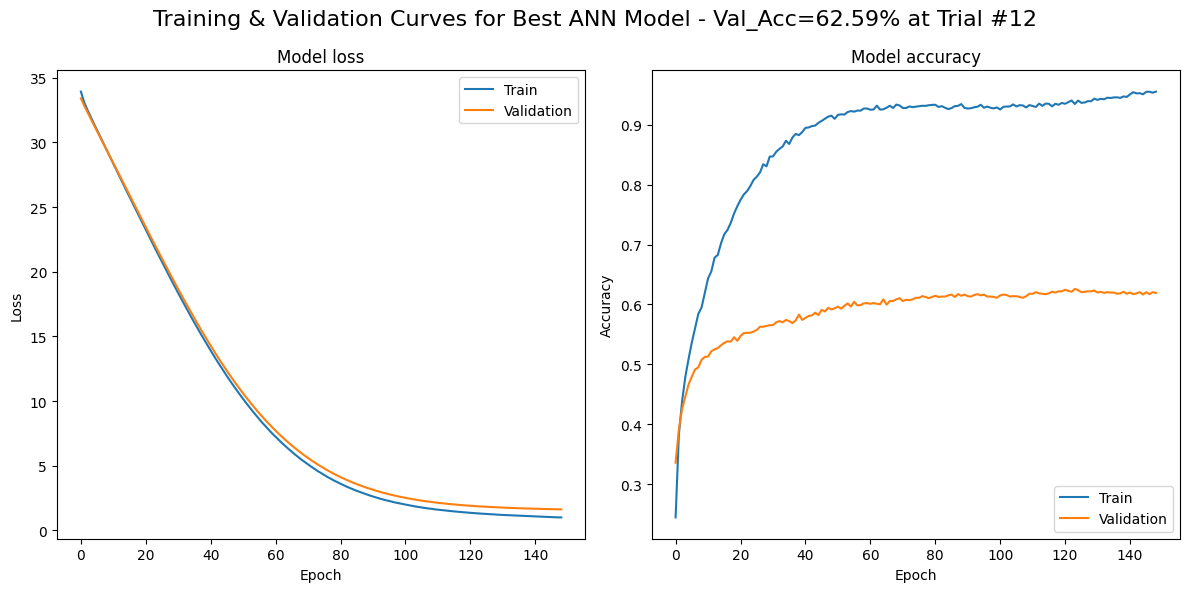

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


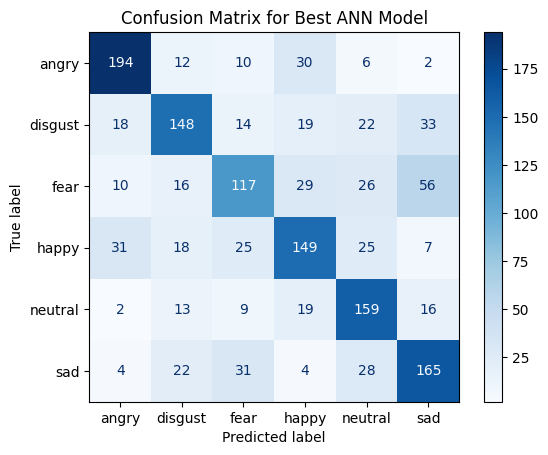


Accuracy = 62.592%

              precision    recall  f1-score   support

       angry       0.75      0.76      0.76       254
     disgust       0.65      0.58      0.61       254
        fear       0.57      0.46      0.51       254
       happy       0.60      0.58      0.59       255
     neutral       0.60      0.73      0.66       218
         sad       0.59      0.65      0.62       254

    accuracy                           0.63      1489
   macro avg       0.62      0.63      0.62      1489
weighted avg       0.63      0.63      0.62      1489



In [46]:
max_acc, best_params, best_trial, best_model, phist, histories = tune_hyperparams(ntrials=20,feats=feats,max_epochs=500)

In [160]:
data = []
for params, acc in phist.items():
    hppms = dict(params)
    hppms['accuracy'] = acc
    data.append(hppms)
df = pd.DataFrame(data)
df = df.reindex(sorted(df.columns), axis=1)
df = df[[col for col in sorted(df.columns) if col != 'accuracy'] + ['accuracy']]
df.sort_values('accuracy',ascending=False,inplace=True,ignore_index=True)
df

,BN_1,BN_2,BN_3,BN_4,KR_1,KR_2,KR_3,KR_4,adpLR,batch_size,...,dropout_rate_4,learning_rate,num_HL,optimizer,rs_split,units_1,units_2,units_3,units_4,accuracy
0,False,False,True,NaN,none,l1l2,l2,NaN,False,120,...,NaN,0.004946,3,Nadam,998,222,226,46.0,NaN,0.609805
1,True,True,True,NaN,none,none,l2,NaN,False,60,...,NaN,0.002841,3,Adam,24,218,216,18.0,NaN,0.599731
2,False,True,True,NaN,l1l2,l1l2,l1,NaN,True,80,...,NaN,0.002442,3,RMSprop,290,178,112,134.0,NaN,0.586971
3,True,False,NaN,NaN,none,l2,NaN,NaN,True,56,...,NaN,0.000259,2,Nadam,9,132,56,NaN,NaN,0.584956
4,False,False,False,True,l1,l1l2,none,none,True,88,...,0.5,0.003394,4,Adamax,668,32,62,122.0,78.0,0.584956
5,False,False,NaN,NaN,l1l2,l2,NaN,NaN,False,72,...,NaN,0.000702,2,SGD,637,218,74,NaN,NaN,0.584285
6,True,False,False,NaN,none,l1l2,l2,NaN,True,32,...,NaN,0.004948,3,Adagrad,578,118,234,226.0,NaN,0.582942
7,False,False,True,False,l2,l2,l1,l2,True,112,...,0.2,0.003794,4,SGD,859,142,118,232.0,86.0,0.582942
8,True,False,False,False,l2,l1,l1l2,none,False,68,...,0.4,0.002863,4,Adagrad,453,38,154,124.0,248.0,0.580927
9,True,True,False,NaN,l2,l1,l1l2,NaN,True,64,...,NaN,0.000534,3,Adamax,100,90,108,42.0,NaN,0.578240


In [161]:
numerical_features = df.iloc[:,:-1].select_dtypes(include=['int64', 'float64'])
categorical_features = df.select_dtypes(include=['object', 'category'])
correlation_matrix = numerical_features.corrwith(df['accuracy'], method='pearson')
print(correlation_matrix.sort_values(ascending=False))

dropout_rate_4    0.349989
dropout_rate_3    0.281780
dropout_rate_1    0.136375
units_3           0.105349
units_4           0.020843
learning_rate    -0.010772
num_HL           -0.068962
dropout_rate_2   -0.090588
batch_size       -0.144399
rs_split         -0.169575
units_2          -0.206345
units_1          -0.283668
dtype: float64


In [162]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
for col in categorical_features:
    model = ols(f'accuracy ~ C({col})', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"ANOVA result for {col}:\n", anova_table)

ANOVA result for BN_3:
             sum_sq    df         F    PR(>F)
C(BN_3)   0.002384   1.0  0.742396  0.405783
Residual  0.038527  12.0       NaN       NaN
ANOVA result for BN_4:
             sum_sq   df        F    PR(>F)
C(BN_4)   0.000114  1.0  0.24758  0.644895
Residual  0.001837  4.0      NaN       NaN
ANOVA result for KR_1:
             sum_sq    df        F    PR(>F)
C(KR_1)   0.015100   3.0  2.98092  0.062587
Residual  0.027016  16.0      NaN       NaN
ANOVA result for KR_2:
             sum_sq    df         F    PR(>F)
C(KR_2)   0.008501   3.0  1.348728  0.293933
Residual  0.033615  16.0       NaN       NaN
ANOVA result for KR_3:
             sum_sq    df        F    PR(>F)
C(KR_3)   0.009386   3.0  0.99239  0.435424
Residual  0.031525  10.0      NaN       NaN
ANOVA result for KR_4:
             sum_sq   df         F    PR(>F)
C(KR_4)   0.000427  3.0  0.186695  0.897671
Residual  0.001524  2.0       NaN       NaN
ANOVA result for optimizer:
                 sum_sq    df    